In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint, loguniform

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS



In [39]:
data= pd.read_csv("train.csv", index_col= 0)

# Dropping the 'Unnamed: 0' and 'index' columns as they seem to be identifiers
data = data.drop(['index'], axis=1)

In [40]:
# Replace negative values with zero for specified columns
columns_to_fix = ['AFP (ng/mL)', 'ALT (U/L)', 'AST (U/L)']

for column in columns_to_fix:
    data[column] = data[column].apply(lambda x: max(x, 0))


In [41]:
# Separating features and target variable
X = data.drop('Diagnosis', axis=1)
y = data['Diagnosis']

# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Normalize numerical features
])

# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combining transformers into a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pca = PCA()

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [43]:
# Initialize the classifier for SVM
svc = SVC(kernel='rbf', random_state=42)

# Initialize SFS for SVM
sfs_svc = SFS(svc,
              k_features=(5, 20),  # Adjust the range as needed
              forward=True,
              floating=False,
              scoring='accuracy',  # Or use a different scoring method
              cv=5)

# Perform SFS on the preprocessed data
sfs_svc = sfs_svc.fit(X_train_preprocessed, y_train)

# Select features for SVM
X_train_sfs_svc = sfs_svc.transform(X_train_preprocessed)
X_test_sfs_svc = sfs_svc.transform(X_test_preprocessed)

c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\

In [44]:
# Initialize the classifier for Logistic Regression
logreg = LogisticRegression(random_state=42)

# Initialize SFS for Logistic Regression
sfs_logreg = SFS(logreg,
                 k_features=(5, 20),  # Adjust the range as needed
                 forward=True,
                 floating=False,
                 scoring='accuracy',  # Or use a different scoring method
                 cv=5)

# Perform SFS on the preprocessed data
sfs_logreg = sfs_logreg.fit(X_train_preprocessed, y_train)

# Select features for Logistic Regression
X_train_sfs_logreg = sfs_logreg.transform(X_train_preprocessed)
X_test_sfs_logreg = sfs_logreg.transform(X_test_preprocessed)

c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\anaconda3\envs\dat200_env\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
c:\Users\Kristian Røhne\

In [46]:
# SVM Pipeline with SFS
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svc)
    ('feature_selector', sfs_svc)
])

# Parameter distributions (For SFS, you will typically not randomize over it in the search)
svm_param_dist = {
    'classifier__C': uniform(0.1, 10),
    'classifier__gamma': ['scale', 'auto'] + list(uniform(0.1, 1).rvs(size=10))
}

# RandomizedSearchCV setup
svm_search = RandomizedSearchCV(svm_pipeline, param_distributions=svm_param_dist, n_iter=100, cv=5, scoring='f1_macro', verbose=10, random_state=42, n_jobs=-1)

# Fitting the model
svm_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: ', svm_search.best_params_)

# Best cross-validation score
print('Best cross-validation score: {:.2f}'.format(svm_search.best_score_))

# Test set performance
print('Test-set score: {:.2f}'.format(svm_search.score(X_test, y_test)))

<>:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\Kristian Røhne\AppData\Local\Temp\ipykernel_24068\2741488713.py:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('classifier', svc)
C:\Users\Kristian Røhne\AppData\Local\Temp\ipykernel_24068\2741488713.py:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('classifier', svc)
C:\Users\Kristian Røhne\AppData\Local\Temp\ipykernel_24068\2741488713.py:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('classifier', svc)
C:\Users\Kristian Røhne\AppData\Local\Temp\ipykernel_24068\2741488713.py:6: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('classifier', svc)


TypeError: 'tuple' object is not callable

In [ ]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', sfs_logreg),
    ('classifier', logreg)
])

logreg_param_dist = {
    'classifier__C': loguniform(1e-5, 1e2),
    'classifier__penalty': ['l1', 'l2']
}

logreg_search = RandomizedSearchCV(logreg_pipeline, param_distributions=logreg_param_dist, n_iter=100, cv=5, scoring='f1_macro', verbose=10, random_state=42, n_jobs=-1)

logreg_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: ', logreg_search.best_params_)

# Best cross-validation score
print('Best cross-validation score: {:.2f}'.format(logreg_search.best_score_))

# Test set performance
print('Test-set score: {:.2f}'.format(logreg_search.score(X_test, y_test)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'classifier__C': 0.19123708862553243, 'classifier__penalty': 'l1'}
Best cross-validation score: 0.73
Test-set score: 0.74


In [ ]:
from sklearn.base import clone

def update_pipeline_with_best_params(original_pipeline, best_params):
    # Create a deep copy of the original pipeline to keep it unmodified
    new_pipeline = clone(original_pipeline)
    
    # Set the parameters directly using the best_params dictionary
    new_pipeline.set_params(**best_params)
    
    return new_pipeline

In [ ]:
# For SVM
svm_best_pipeline = update_pipeline_with_best_params(svm_pipeline, svm_search.best_params_)
svm_best_pipeline.fit(X, y)

# For Logistic Regression
logreg_best_pipeline = update_pipeline_with_best_params(logreg_pipeline, logreg_search.best_params_)
logreg_best_pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['AFP (ng/mL)', 'ALP (U/L)', 'ALT (U/L)', 'AST (U/L)', 'Age',
       'Albumin (g/dL)', 'Bilirubin (mg/dL)', 'CRP (mg/L)', 'Fibroscan (kPa)',
       'GGT (U/L)', 'Hemoglobin (g/dL)', 'IL-6 (pg/mL)', 'PT/INR',
       'Platelets (10^9/L)', 'RBC (10^1...
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Alcohol_Use (yes/no)', 'Diabetes (yes/no)', 'Gender',
       'Obesity (yes/no)'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=0.19123708862553243, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='saga'))])

Best model parameters: {'classifier__C': 0.19123708862553243, 'classifier__penalty': 'l1'}
Best model score: 0.729993530790372


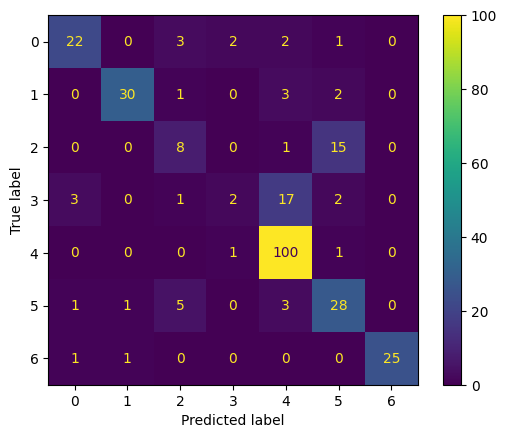

In [ ]:
# Evaluate and select the best model
best_model = svm_search if svm_search.best_score_ > logreg_search.best_score_ else logreg_search
print(f"Best model parameters: {best_model.best_params_}")
print(f"Best model score: {best_model.best_score_}")

# Confusion Matrix for the Best Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
best_model.best_estimator_.fit(X_train, y_train)
y_pred = best_model.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Load the test data
test_data = pd.read_csv("test.csv", index_col=0)

# Dropping the 'Unnamed: 0' and 'index' columns as they seem to be identifiers
test_data = test_data.drop(['index'], axis=1)

# Make predictions for submission using both retrained models
svm_predictions = svm_best_pipeline.predict(test_data)
logreg_predictions = logreg_best_pipeline.predict(test_data)

# Create submission files for each model
svm_submission_df = pd.DataFrame({
    'index': test_data.index,
    'Diagnosis': svm_predictions
})
logreg_submission_df = pd.DataFrame({
    'index': test_data.index,
    'Diagnosis': logreg_predictions
})

# Save the DataFrames to CSV files for submission
svm_submission_df.to_csv('svm_submission.csv', index=False)
logreg_submission_df.to_csv('logreg_submission.csv', index=False)
